In [1]:
# imports
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import numpy as np
import pandas as pd
import random

In [2]:
# To connect with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Preprocessing**

In [3]:
def preprocess_data(train_dir, test_dir, batch_size=64):
    train_transforms = transforms.Compose([
        transforms.Resize(256),                  # Resize each image to 256x256
        transforms.CenterCrop(224),              # Crop the image around the center to 224x224
        transforms.RandomHorizontalFlip(),       # Randomly flip the images horizontally (data augmentation)
        transforms.ToTensor(),                   # Convert the image to a PyTorch Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image with ImageNet mean and std
    ])

    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load the datasets with ImageFolder
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

    # Using DataLoader to batch and shuffle the dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset

**1. Resize and Crop:**

transforms.Resize(256): This resizes every input image to 256x256 pixels. Resizing helps standardize the input dimensions and often makes computation more manageable as deep learning models typically require inputs of consistent size.

transforms.CenterCrop(224): This crops the images around the center to 224x224 pixels. This step is commonly used to remove less informative parts of the image at the edges and to further standardize the input size, especially after resizing which might not always give images in the exact dimensions required by the model.

**2. Data Augmentation**

transforms.RandomHorizontalFlip(): Used only in the training data transformation to introduce horizontal flipping of images randomly. This form of augmentation helps the model generalize better by teaching it that the relevant features for classification or detection can appear in either orientation. It simulates a scenario where objects of interest can face either direction, increasing the robustness of the model.

**3. Conversion and Normalization:**

transforms.ToTensor(): Converts the images from PIL format or NumPy arrays into PyTorch tensors. This conversion is essential because PyTorch models process tensors, not raw image files.

transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): Normalizes the image data by adjusting each color channel. The means [0.485, 0.456, 0.406] and standard deviations [0.229, 0.224, 0.225] are the normalization statistics from the ImageNet dataset. This step ensures that the model receives data similar in distribution to its original training set, facilitating more effective learning and prediction.

**4. ImageFolder:**

datasets.ImageFolder(train_dir, transform=train_transforms) and datasets.ImageFolder(test_dir, transform=test_transforms): These load images from directories, where each subdirectory in train_dir and test_dir is treated as a different class. The ImageFolder class is convenient for loading data without manually assigning labels, as it automatically infers the labels from the directory structure.


**5. DataLoader:**

DataLoader(train_dataset, batch_size=batch_size, shuffle=True): Prepares the training dataset for loading in batches of size batch_size and shuffles the data to ensure randomness, which is crucial for effective training. Shuffling helps prevent the model from learning the order of data, a potential source of bias that could impair generalization.

DataLoader(test_dataset, batch_size=batch_size, shuffle=False): Prepares the test dataset similarly in batches but without shuffling, as the order does not affect testing and evaluation.

In [4]:
# Specify the paths to train and test directories
train_dir = './drive/MyDrive/MSDS-634/train' # Change to own path with train directory
test_dir = './drive/MyDrive/MSDS-634/test' # Change to own path with test directory

# Preprocess the data
train_loader, test_loader, train_dataset, test_dataset = preprocess_data(train_dir, test_dir)

In [5]:
# Counting Classes
def count_classes(directory):
    """Count the number of subdirectories in the given directory."""
    # List all entries in the directory
    entries = os.listdir(directory)
    # Filter out only directories
    subdirs = [entry for entry in entries if os.path.isdir(os.path.join(directory, entry))]
    return len(subdirs)

num_classes = count_classes(train_dir)

#**Methods**

In this project, we employed several methodologies to evaluate and compare the performance of different convolutional neural networks (CNNs) on image classification tasks. The algorithms used included a Simple CNN, a Simple CNN with L2 Regularization, and a Simple CNN with Stochastic Gradient Descent (SGD), L2 Regularization, and a learning rate scheduler. A Simple CNN is a basic convolutional neural network architecture trained using the Adam optimizer. When L2 Regularization is added, it helps prevent overfitting by penalizing large weights. In contrast, a Simple CNN with Stochastic Gradient Descent (SGD), L2 Regularization, and a learning rate scheduler not only incorporates the regularization to control overfitting but also uses SGD to optimize the network and dynamically adjusts the learning rate during training to potentially improve convergence and performance stability.

Additionally, we experimented with more complex architectures such as ResNet 18 and ResNet 50, as well as EfficientNet variants (EfficientNet B0 and EfficientNet B4). ResNet architectures incorporate residual blocks which allow deeper networks to be trained more effectively by mitigating the vanishing gradient problem. EfficientNet, on the other hand, optimizes both the network depth, width, and resolution using a compound scaling method, resulting in a more balanced and efficient model compared to a Simple CNN.

Each model was trained using standardized training procedures to ensure reproducibility and comparability of results.

# Simple Convolutional Neural Network

In [6]:
# Defining the model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=num_classes).to(device)  # Adjust num_classes as necessary

In [ ]:
# Setting the seed
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(0)

Random seed set as 0


In [ ]:
# Training the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1, Loss: 4.451662424448374
Epoch 2, Loss: 3.227783589749723
Epoch 3, Loss: 3.077024485613849
Epoch 4, Loss: 2.8867308835725525
Epoch 5, Loss: 2.544619611791662
Epoch 6, Loss: 2.0621512032843925
Epoch 7, Loss: 1.5256903719257664
Epoch 8, Loss: 0.9781447697330166
Epoch 9, Loss: 0.6059045187524847
Epoch 10, Loss: 0.3274540264864226


In [ ]:
def test_model(model, test_loader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy}%')

    # Calculate F1-score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

In [ ]:
test_model(model, test_loader)

Accuracy of the network on the test images: 18.220338983050848%
F1 Score (Weighted): 0.15146084728608208


**With Regularization**

In [ ]:
class SimpleRegCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleRegCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Dropout added here
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout added here
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x

reg_model = SimpleRegCNN(num_classes=28).to(device)
optimizer = optim.Adam(reg_model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
train_model(reg_model, train_loader, criterion, optimizer, num_epochs=15)

Epoch 1, Loss: 6.187685818285556
Epoch 2, Loss: 3.261487187565984
Epoch 3, Loss: 3.206738182016321
Epoch 4, Loss: 3.103198850477064
Epoch 5, Loss: 3.0199544172029236
Epoch 6, Loss: 2.9537113872734277
Epoch 7, Loss: 2.896187241012986
Epoch 8, Loss: 2.8280076207341374
Epoch 9, Loss: 2.7405045225813582
Epoch 10, Loss: 2.671422545974319
Epoch 11, Loss: 2.529604570285694
Epoch 12, Loss: 2.3902654776702055
Epoch 13, Loss: 2.210930672851769
Epoch 14, Loss: 2.073982844481597
Epoch 15, Loss: 1.8802935207212292


In [ ]:
test_model(reg_model, test_loader)

Accuracy of the network on the test images: 11.016949152542374%
F1 Score (Weighted): 0.08775200407716652


**With Stochastic Gradient Descent, Regularization and Scheduler**

In [7]:
from torch.optim.lr_scheduler import StepLR
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Step the scheduler after each epoch
        scheduler.step()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

stoch_model = SimpleCNN(num_classes=num_classes).to(device)  # Model function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(stoch_model, train_loader, criterion, optimizer, scheduler, num_epochs=15, device='cpu')

Epoch 1, Loss: 3.179484882870236
Epoch 2, Loss: 3.018075775455784
Epoch 3, Loss: 2.8310132735484355
Epoch 4, Loss: 2.6627094036823995
Epoch 5, Loss: 2.4652851304492436
Epoch 6, Loss: 2.2062380346092016
Epoch 7, Loss: 1.8193563609509855
Epoch 8, Loss: 1.0183472810564815
Epoch 9, Loss: 0.773737865525323
Epoch 10, Loss: 0.6406855744284552
Epoch 11, Loss: 0.5162807098917059
Epoch 12, Loss: 0.40914347445642624
Epoch 13, Loss: 0.3243822016426035
Epoch 14, Loss: 0.26073184005312017
Epoch 15, Loss: 0.1986082347260939


In [ ]:
test_model(stoch_model, test_loader)

Accuracy of the network on the test images: 16.10169491525424%
F1 Score (Weighted): 0.1480259592552006


# ResNet 18

In [ ]:
# Defining the model
def create_pretrained_model(num_classes):
    # Load a pre-trained ResNet-18 model
    model = models.resnet18(pretrained=True)

    # Replace the final fully connected layer to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

In [ ]:
# Training the Model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

In [ ]:
def test_model(model, test_loader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy}%')

    # Calculate F1-score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

In [ ]:
# Create the pre-trained model
res_18_model = create_pretrained_model(num_classes)
optimizer = torch.optim.Adam(res_18_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.7MB/s]


In [ ]:
# Training loop
train_model(res_18_model, train_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch 1, Loss: 2.053718160938572
Epoch 2, Loss: 1.3692072952115857
Epoch 3, Loss: 0.940948090037784
Epoch 4, Loss: 0.778252545240763
Epoch 5, Loss: 0.5673486115159215
Epoch 6, Loss: 0.4445066009018872
Epoch 7, Loss: 0.3816079855770678
Epoch 8, Loss: 0.36860674579401276
Epoch 9, Loss: 0.34122880044821147
Epoch 10, Loss: 0.29365684897513


In [ ]:
# Testing Results
test_model(res_18_model, test_loader, device=device)

Accuracy of the network on the test images: 40.25423728813559%
F1 Score (Weighted): 0.3666380717501854


# Efficient Net 0

In [ ]:
# Defining the model
def create_pretrained_efficientnet(num_classes):
    # Load a pre-trained EfficientNet-B0
    model = models.efficientnet_b0(pretrained=True)

    # Replace the classifier layer
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    return model

# Create the pre-trained model
net_0_model = create_pretrained_efficientnet(num_classes)

# Set up optimizer
optimizer = torch.optim.Adam(net_0_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 82.6MB/s]


In [ ]:
# Training Loop
train_model(net_0_model, train_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch 1, Loss: 2.00222939413947
Epoch 2, Loss: 0.9007772948290851
Epoch 3, Loss: 0.5680498956023036
Epoch 4, Loss: 0.38622780265034856
Epoch 5, Loss: 0.30129458372657364
Epoch 6, Loss: 0.2559466186810184
Epoch 7, Loss: 0.23806726288151098
Epoch 8, Loss: 0.18981497452871218
Epoch 9, Loss: 0.14092025321883125
Epoch 10, Loss: 0.14354246895055514


In [ ]:
# Testing Results
test_model(net_0_model, test_loader, device=device)

Accuracy of the network on the test images: 47.45762711864407%
F1 Score (Weighted): 0.47404671235547036


# ResNet 50

In [ ]:
def create_pretrained_model(num_classes):
    # Load a pre-trained ResNet-50 model
    model = models.resnet50(pretrained=True)

    # Replace the final fully connected layer to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

In [ ]:
res_50_model = create_pretrained_model(num_classes)

# Set up loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_50_model.parameters(), lr=0.001)

# Training and testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 113MB/s]


In [ ]:
train_model(res_50_model, train_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch 1, Loss: 2.43699514543688
Epoch 2, Loss: 1.7665844930184853
Epoch 3, Loss: 1.5082206436105676
Epoch 4, Loss: 1.3089014195107125
Epoch 5, Loss: 1.1097415427903872
Epoch 6, Loss: 1.0651415248174925
Epoch 7, Loss: 0.8421571931323489
Epoch 8, Loss: 0.7758747323139293
Epoch 9, Loss: 0.7265614617515255
Epoch 10, Loss: 0.6148334806029861


In [ ]:
test_model(res_50_model, test_loader, device=device)

Accuracy of the network on the test images: 39.40677966101695%
F1 Score (Weighted): 0.37661299605204734


# Efficient Net B4

In [ ]:
# Defining the model
def create_pretrained_efficientnet(num_classes):
    # Load a pre-trained EfficientNet-B4
    model = models.efficientnet_b4(pretrained=True)

    # Replace the classifier layer
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    return model

# Create the pre-trained model
b4_model = create_pretrained_efficientnet(num_classes)

# Set up loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(b4_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:18<00:00, 4.16MB/s]


In [ ]:
train_model(b4_model, train_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch 1, Loss: 2.5269427976092778
Epoch 2, Loss: 1.1300817953573692
Epoch 3, Loss: 0.5724707471357809
Epoch 4, Loss: 0.32019886716797546
Epoch 5, Loss: 0.2030192619642696
Epoch 6, Loss: 0.12014357725510726
Epoch 7, Loss: 0.12623857087581544
Epoch 8, Loss: 0.11929479070209167
Epoch 9, Loss: 0.11257407369998258
Epoch 10, Loss: 0.09229098245300152


In [ ]:
test_model(b4_model, test_loader, device=device)

Accuracy of the network on the test images: 55.932203389830505%
F1 Score (Weighted): 0.5345566804554545


# **Experiments and Results**

<ipython-input-14-ac22e2da833d>:23: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
<ipython-input-14-ac22e2da833d>:24: RuntimeWarning: invalid value encountered in cast
  cm_normalized_rounded = np.round(cm_normalized * 100).astype(int)


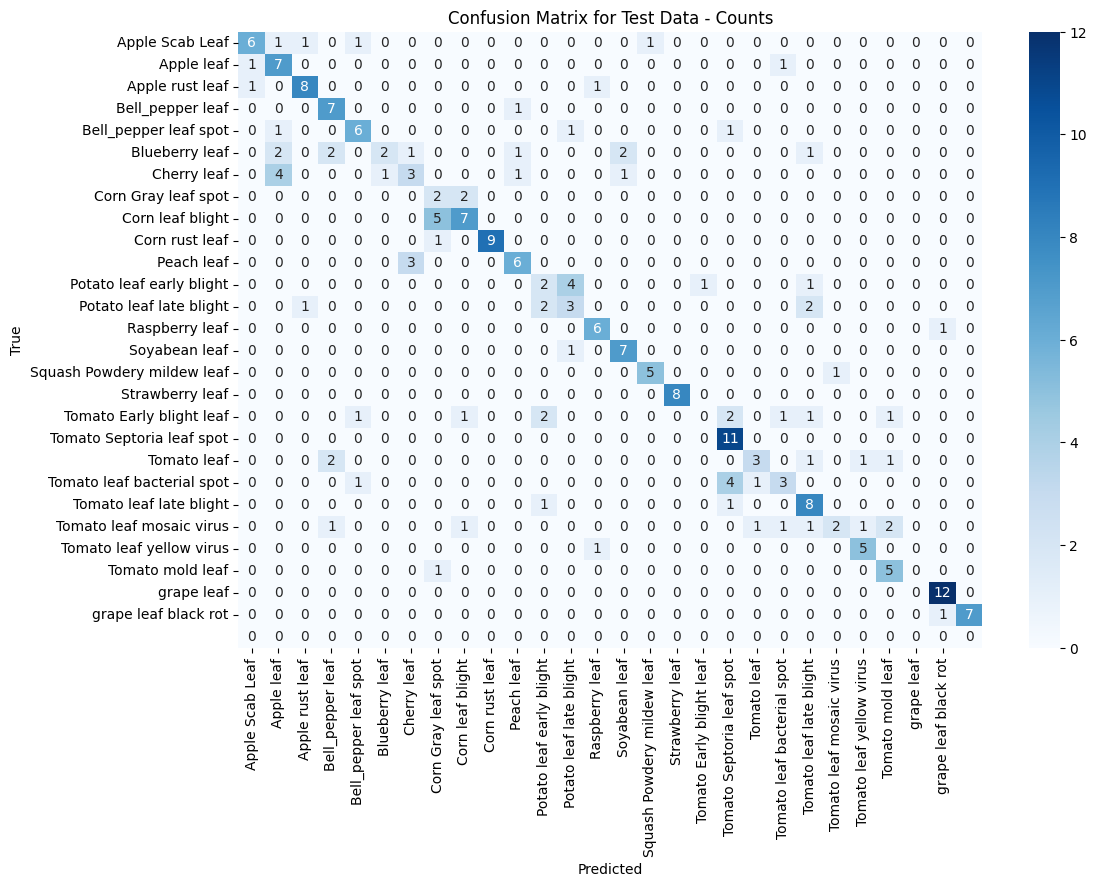

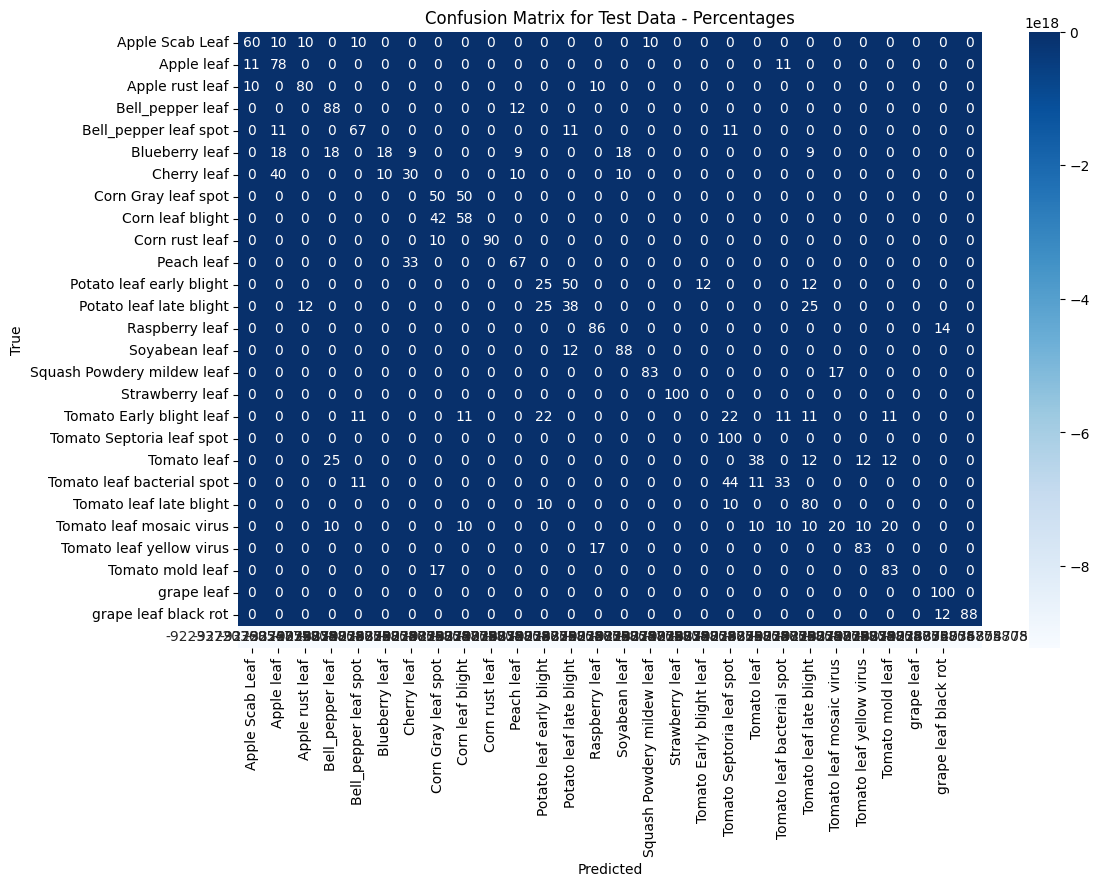

In [ ]:
#Create Confusion Matrices for our final EfficientNet B4 model

import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, test_loader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return all_labels, all_predictions

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized_rounded = np.round(cm_normalized * 100).astype(int)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{title} - Counts')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_normalized_rounded, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{title} - Percentages')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Test the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
b4_model.to(device)

y_true, y_pred = test_model(b4_model, test_loader, device=device)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, test_dataset.classes, 'Confusion Matrix for Test Data')

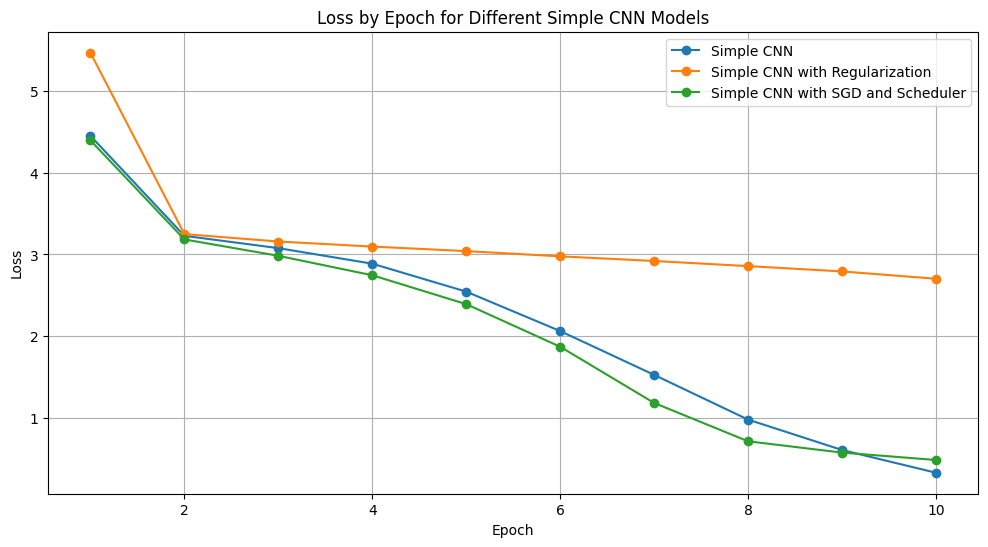

In [ ]:
import matplotlib.pyplot as plt

# Losses by epoch for each model
epochs = list(range(1, 11))

# Simple CNN losses
losses_simple_cnn = [
    4.451662424448374, 3.227783589749723, 3.077024485613849,
    2.8867308835725525, 2.544619611791662, 2.0621512032843925,
    1.5256903719257664, 0.9781447697330166, 0.6059045187524847,
    0.3274540264864226
]

# Simple CNN with Regularization losses
losses_simple_cnn_reg = [
    5.469374173396343, 3.2488829123007283, 3.1579565937454634,
    3.0961495541237496, 3.0403970254434123, 2.976635507635168,
    2.919730044700004, 2.8570446130391716, 2.791895821287825,
    2.7022226630030453
]

# Simple CNN with SGD and Scheduler losses
losses_simple_cnn_sgd_sched = [
    4.396423894005853, 3.183807894990251, 2.983151867582991,
    2.7450615586461247, 2.3914914195602006, 1.8700147319484401,
    1.182295472235293, 0.7124074923025595, 0.5738583295731932,
    0.48336895253207235
]

# Plotting the losses
plt.figure(figsize=(12, 6))

plt.plot(epochs, losses_simple_cnn, marker='o', label='Simple CNN')
plt.plot(epochs, losses_simple_cnn_reg, marker='o', label='Simple CNN with Regularization')
plt.plot(epochs, losses_simple_cnn_sgd_sched, marker='o', label='Simple CNN with SGD and Scheduler')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch for Different Simple CNN Models')
plt.legend()
plt.grid(True)
plt.show()

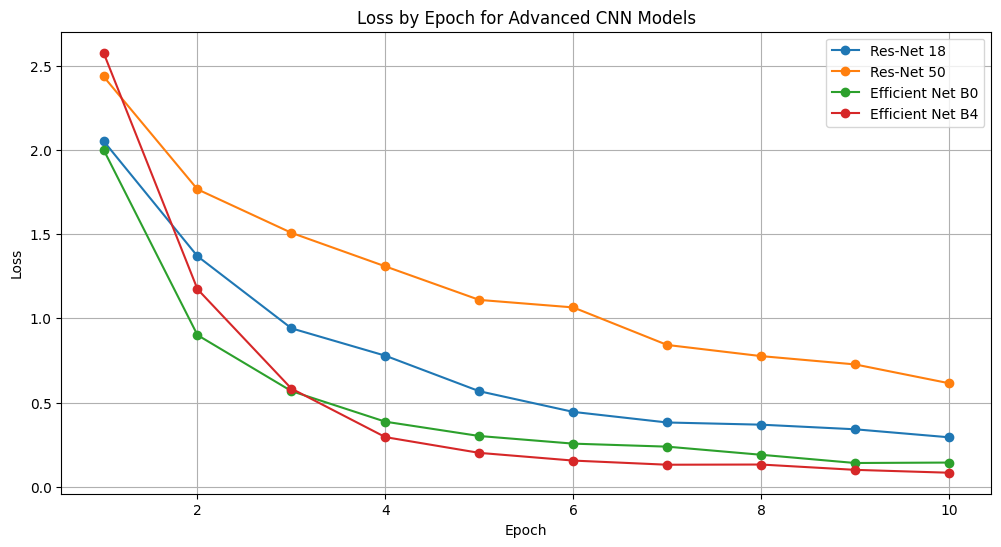

In [ ]:
import matplotlib.pyplot as plt

# Losses by epoch for each model
epochs = list(range(1, 11))

# Res-Net 18 losses
losses_resnet18 = [
    2.053718160938572, 1.3692072952115857, 0.940948090037784,
    0.778252545240763, 0.5673486115159215, 0.4445066009018872,
    0.3816079855770678, 0.36860674579401276, 0.34122880044821147,
    0.29365684897513
]

# Res-Net 50 losses
losses_resnet50 = [
    2.43699514543688, 1.7665844930184853, 1.5082206436105676,
    1.3089014195107125, 1.1097415427903872, 1.0651415248174925,
    0.8421571931323489, 0.7758747323139293, 0.7265614617515255,
    0.6148334806029861
]

# Efficient Net B0 losses
losses_efficientnet_b0 = [
    2.00222939413947, 0.9007772948290851, 0.5680498956023036,
    0.38622780265034856, 0.30129458372657364, 0.2559466186810184,
    0.23806726288151098, 0.18981497452871218, 0.14092025321883125,
    0.14354246895055514
]

# Efficient Net B4 losses
losses_efficientnet_b4 = [
    2.578060746192932, 1.1733748832264461, 0.5827130159816226,
    0.29463545092054316, 0.20107363496680516, 0.15532612387795705,
    0.1306800892626917, 0.1318249136612222, 0.10024009604711791,
    0.08318335394299514
]

# Plotting the losses
plt.figure(figsize=(12, 6))

plt.plot(epochs, losses_resnet18, marker='o', label='Res-Net 18')
plt.plot(epochs, losses_resnet50, marker='o', label='Res-Net 50')
plt.plot(epochs, losses_efficientnet_b0, marker='o', label='Efficient Net B0')
plt.plot(epochs, losses_efficientnet_b4, marker='o', label='Efficient Net B4')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch for Advanced CNN Models')
plt.legend()
plt.grid(True)
plt.show()

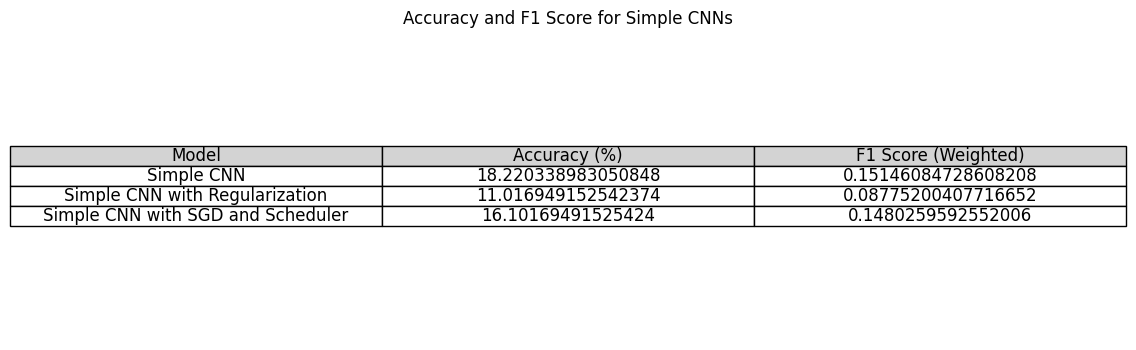

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Model': ['Simple CNN', 'Simple CNN with Regularization', 'Simple CNN with SGD and Scheduler'],
    'Accuracy (%)': [18.220338983050848, 11.016949152542374, 16.10169491525424],
    'F1 Score (Weighted)': [0.15146084728608208, 0.08775200407716652, 0.1480259592552006]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting the table
fig, ax = plt.subplots(figsize=(12, 4))  # Adjusted size for better readability
ax.axis('tight')
ax.axis('off')
table_data = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=['lightgrey']*len(df.columns))

table_data.auto_set_font_size(False)
table_data.set_fontsize(12)
table_data.scale(1.2, 1.2)

plt.title("Accuracy and F1 Score for Simple CNNs")
plt.show()

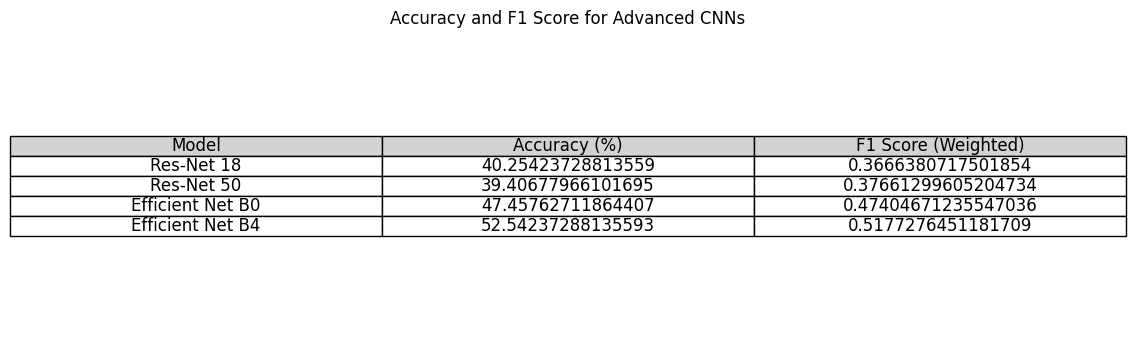

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Model': ['Res-Net 18', 'Res-Net 50', 'Efficient Net B0', 'Efficient Net B4'],
    'Accuracy (%)': [40.25423728813559, 39.40677966101695, 47.45762711864407, 52.54237288135593],
    'F1 Score (Weighted)': [0.3666380717501854, 0.37661299605204734, 0.47404671235547036, 0.5177276451181709]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting the table
fig, ax = plt.subplots(figsize=(12, 4))  # Adjusted size for better readability
ax.axis('tight')
ax.axis('off')
table_data = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=['lightgrey']*len(df.columns))

table_data.auto_set_font_size(False)
table_data.set_fontsize(12)
table_data.scale(1.2, 1.2)

plt.title("Accuracy and F1 Score for Advanced CNNs")
plt.show()

Our best model was EfficientNet-B4. We've included a Model Implementation section below to elaborate on why it outperformed the other models that we experimented with.

# **EfficientNet-B4 Model Implementation**

EfficientNet-B4 is built upon the base EfficientNet architecture, which uses a combination of depthwise separable convolutions, MBConv blocks (an inverted residual structure), and Squeeze-and-Excitation blocks. This architecture provides a powerful, yet efficient, method for feature extraction by leveraging these specialized blocks.

The EfficientNet models use a compound coefficient to uniformly scale the network in three dimensions (width, depth, and resolution). For EfficientNet-B4, these coefficients are higher than those of its predecessor, B0.

The default input resolution for EfficientNet-B4 is 380x380 pixels, which is higher than that of B0. This increased resolution allows the model to capture more detailed features in the input images. It also has more layers and channels than B0.

The model is initialized with pre-trained weights from the ImageNet dataset. We use num_ftrs = model.classifier[1].in_features and model.classifier[1] = nn.Linear(num_ftrs, num_classes) to ensure that the dimensions are correct.

We use CrossEntropyLoss() as our metric because this is a multiclass classification problem. The Adam optimizer is chosen for its effectiveness in handling sparse gradients and adapting the learning rate during training, and because it performed better than the SGD optimizer in our experiments.

Here is a link to EfficientNet B4 in Pytorch: [https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b4.html]

Here is a link to the EfficientNet research paper: [https://arxiv.org/abs/1905.11946](https://)